<H3>Task 1: How well can you classify individual micros assuming all micros per subject have the same label?</H3>

- A patient has cancer or not (all micros are malignant or benign)
- Classification problem



In [1]:
import joblib
import numpy as np
import pandas as pd
from sklearn import svm
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, RocCurveDisplay

Taking a first glance at the dataset

In [2]:
df = pd.read_excel('Reduced_Features_for_TAI_project.xlsx')

# separating the 0 and 1 labels just in case it's useful later
df_negatives = df[df['Label'] == 0] # healthy
df_positives = df[df['Label'] == 1] # lesion
labels_GT = df[['Patient ID', 'Label']].copy() # saving the original labels of the micros to compare to later

df.drop(columns=['Patient ID', 'Label'], axis=1, inplace=True) # dropping the Patient ID and Label columns as we don't want to give that information to the model

# Let's see how the data looks like
print(df.head())
df.describe()

   original_shape_Elongation  original_firstorder_Kurtosis  \
0                   0.661690                      2.817688   
1                   0.750849                      2.084800   
2                   0.619781                      2.590759   
3                   0.388733                      2.932863   
4                   0.820531                      2.814081   

   original_firstorder_Skewness  wavelet-LHL_glrlm_RunVariance  \
0                      0.769536                       7.257078   
1                      0.442780                       3.137745   
2                      0.384512                       7.005413   
3                      0.738215                       2.178815   
4                      0.773252                       1.316850   

   wavelet2-LHL_gldm_LargeDependenceEmphasis  \
0                                3381.734540   
1                                2653.808184   
2                                3551.125894   
3                                1564.

,original_shape_Elongation,original_firstorder_Kurtosis,original_firstorder_Skewness,wavelet-LHL_glrlm_RunVariance,wavelet2-LHL_gldm_LargeDependenceEmphasis,wavelet2-LLH_gldm_LargeDependenceEmphasis,wavelet-LHL_gldm_LargeDependenceEmphasis,wavelet2-LHL_gldm_DependenceVariance,wavelet2-LHL_glrlm_RunVariance,wavelet-LHL_glrlm_LongRunEmphasis,...,wavelet-HHH_glrlm_LongRunHighGrayLevelEmphasis,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet2-HHH_firstorder_RootMeanSquared,wavelet2-LLH_firstorder_Kurtosis,wavelet-HHL_glcm_Imc2,wavelet2-LHH_firstorder_RobustMeanAbsoluteDeviation,original_shape_SphericalDisproportion,wavelet2-HHL_glcm_Idmn,wavelet2-LHH_firstorder_RootMeanSquared,wavelet2-HLL_firstorder_Maximum
count,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,...,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000
mean,0.666190,2.462975,0.590587,4.212117,1497.921542,1594.268004,2119.089859,271.458163,2.968610,11.251502,...,9.493928,263.808079,0.351824,3.164037,0.159556,0.458397,1.292847,0.931269,0.905466,73.400175
std,0.168063,0.546251,0.272699,4.286353,1289.535822,1387.119079,1528.700938,218.219184,3.454322,8.819559,...,8.463617,2184.304828,0.216732,1.182988,0.162182,0.243215,0.247532,0.035136,0.512119,81.520035
min,0.039069,0.000000,-1.005865,0.083283,1.000000,1.000000,1.000000,0.000000,0.054849,1.256063,...,2.040067,0.030881,0.058536,1.284810,0.000000,0.122810,0.907201,0.811843,0.234128,3.099939
25%,0.550945,2.153519,0.450615,0.963731,316.233814,327.236986,637.213037,54.969021,0.654501,4.320566,...,6.113958,10.276716,0.191192,2.531290,0.043387,0.322079,1.154897,0.902421,0.628734,22.119894
50%,0.677985,2.371766,0.580983,2.686606,1247.979233,1297.284496,2121.746771,249.695632,1.718228,8.927913,...,8.837889,31.876325,0.295743,2.917387,0.086336,0.410345,1.224399,0.920535,0.801215,35.270240
75%,0.793857,2.665746,0.726457,6.188729,2428.843420,2579.808869,3397.403762,453.547995,3.987678,15.864163,...,11.523476,111.915767,0.468013,3.432697,0.248412,0.530553,1.356257,0.962220,1.035546,102.038460
max,1.000000,8.111111,2.666667,29.198575,6454.319835,6484.443965,6308.111352,913.448742,31.799360,71.411609,...,295.617964,99073.022883,2.957963,22.889047,0.929873,5.265915,3.486119,1.000000,9.730689,675.982582


In [3]:
# Search for possible empty or NaN values in the dataframe to clean up
print(f"Searching for NaN values: {np.where(pd.isnull(df))}")
print(f"Searching for empty values: {np.where(df.map(lambda x: x == ''))}")

Searching for NaN values: (array([], dtype=int64), array([], dtype=int64))
Searching for empty values: (array([], dtype=int64), array([], dtype=int64))


We know now there are no empty or NaN values to be cleaned out of the dataset

In [4]:
df_negatives.describe()

,Patient ID,original_shape_Elongation,original_firstorder_Kurtosis,original_firstorder_Skewness,wavelet-LHL_glrlm_RunVariance,wavelet2-LHL_gldm_LargeDependenceEmphasis,wavelet2-LLH_gldm_LargeDependenceEmphasis,wavelet-LHL_gldm_LargeDependenceEmphasis,wavelet2-LHL_gldm_DependenceVariance,wavelet2-LHL_glrlm_RunVariance,...,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet2-HHH_firstorder_RootMeanSquared,wavelet2-LLH_firstorder_Kurtosis,wavelet-HHL_glcm_Imc2,wavelet2-LHH_firstorder_RobustMeanAbsoluteDeviation,original_shape_SphericalDisproportion,wavelet2-HHL_glcm_Idmn,wavelet2-LHH_firstorder_RootMeanSquared,wavelet2-HLL_firstorder_Maximum,Label
count,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,...,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.0
mean,25.629208,0.671023,2.541160,0.632821,3.321986,1236.248451,1320.382140,1818.425807,232.680590,2.258851,...,178.060701,0.367301,3.059539,0.153275,0.479440,1.308693,0.928895,0.945080,70.026105,0.0
std,13.435357,0.167790,0.592647,0.273972,3.400728,1116.404818,1228.398235,1411.280549,199.957520,2.581544,...,1547.136954,0.210378,1.151980,0.153703,0.218367,0.274760,0.035312,0.462994,80.628899,0.0
min,1.000000,0.198762,1.000000,-0.595228,0.103922,1.000000,1.600000,1.000000,0.000000,0.054849,...,0.046149,0.058536,1.284810,0.000000,0.134837,0.907201,0.811843,0.234128,5.736444,0.0
25%,11.000000,0.551223,2.202585,0.484116,0.803612,236.207407,238.635834,444.799470,37.589619,0.552561,...,10.601224,0.212227,2.493330,0.045371,0.347143,1.152852,0.900626,0.677886,22.238506,0.0
50%,32.000000,0.680345,2.428700,0.617136,2.097888,956.041056,1001.591082,1684.379144,191.550539,1.393530,...,31.490510,0.306185,2.849771,0.085443,0.431634,1.231523,0.918179,0.853759,34.148616,0.0
75%,36.000000,0.797426,2.762318,0.762858,4.757779,1973.992690,2085.831565,2981.890057,394.862011,2.896822,...,89.861111,0.482182,3.315686,0.231550,0.554190,1.377855,0.958302,1.082816,93.145994,0.0
max,46.000000,1.000000,8.111111,2.666667,25.203036,5889.561452,5857.746937,5927.993687,806.808143,25.262535,...,63032.030205,2.335138,22.889047,0.929873,3.971937,3.486119,1.000000,8.059251,675.982582,0.0


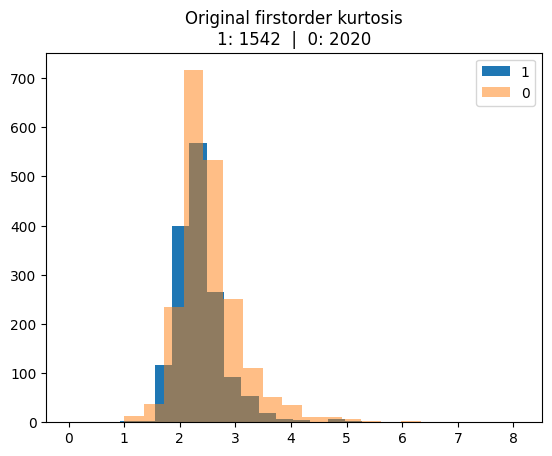

In [5]:
# Plotting some histograms for positive and negative values to see how it looks like and if there is a visual difference
plt.hist(df_positives['original_firstorder_Kurtosis'], bins=20, label='1')
plt.hist(df_negatives['original_firstorder_Kurtosis'], bins=20, alpha=0.5, label='0')
plt.legend()
plt.title(f"Original firstorder kurtosis\n1: {len(df_positives['original_firstorder_Kurtosis'])}  |  0: {len(df_negatives['original_firstorder_Kurtosis'])}")

plt.show()

<h4>Starting with simple models <br></h4>
<h3>Linear model</h3>

Selecting the most significant features and dropping the non-significant from the dataset

In [6]:
# ----------------------------------------------------------- Linear model -------------------------------------------------------
                                                                               
# df is X, GT_labels is Y
testSize = 0.2
X_train, X_test, y_train, y_test = train_test_split(df, labels_GT, test_size=testSize, random_state=100) # splitting on train and test (trying with 0.1)
y_train = y_train.iloc[:, -1] # leaving out the id of the labels
y_test = y_test.iloc[:, -1]

model = LogisticRegression(max_iter=1000)

# Feature selector to filter out the less significant features. This gets rid of "noise" and leaves only the important parts
# making the dataseat also lighter and easier to use and understand
selector = SelectFromModel(estimator=model, threshold='median') 
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]

X_train_selected = selector.transform(X_train) # reduce X to the selected features
X_test_selected = selector.transform(X_test)

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
# show selected features that passed the criteria
print(f"Selected {X_train_selected.shape[1]} features!")
print(f"\n\nThe selected features were:\n{selector.get_feature_names_out()}")

Selected 75 features!


The selected features were:
['original_firstorder_Kurtosis' 'original_firstorder_Skewness'
 'wavelet-LHL_glrlm_RunVariance'
 'wavelet2-LHL_gldm_LargeDependenceEmphasis'
 'wavelet2-LLH_gldm_LargeDependenceEmphasis'
 'wavelet-LHL_gldm_LargeDependenceEmphasis'
 'wavelet2-LHL_gldm_DependenceVariance' 'wavelet2-LHL_glrlm_RunVariance'
 'wavelet-LHL_glrlm_LongRunEmphasis' 'wavelet-LHH_glrlm_LongRunEmphasis'
 'wavelet-LHH_glrlm_RunPercentage' 'wavelet2-LLH_glrlm_RunVariance'
 'wavelet-HHH_glrlm_LongRunEmphasis' 'wavelet2-LHH_glrlm_LongRunEmphasis'
 'wavelet2-LHH_glrlm_RunPercentage' 'wavelet-LHL_glrlm_RunPercentage'
 'wavelet2-HHH_glrlm_RunPercentage'
 'wavelet-LHH_glrlm_LongRunLowGrayLevelEmphasis'
 'wavelet2-LLH_glrlm_RunPercentage' 'wavelet-LHH_glrlm_ShortRunEmphasis'
 'log-sigma-3-0-mm-3D_glrlm_RunPercentage'
 'original_glrlm_LowGrayLevelRunEmphasis'
 'wavelet-HHH_glrlm_RunPercentage' 'original_glrlm_RunPercentage'
 'wavelet-HHL_glrlm_LongRunEmphasis'
 'wavelet-HHH_

In [8]:
# Training on the selected features
model.fit(X_train_selected, y_train)
accuracy = model.score(X_test_selected, y_test)
print(f"Accuracy: {accuracy}\n\n")

Accuracy: 0.7180925666199158




c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[337  70]
 [131 175]]


              precision    recall  f1-score   support

           0       0.72      0.83      0.77       407
           1       0.71      0.57      0.64       306

    accuracy                           0.72       713
   macro avg       0.72      0.70      0.70       713
weighted avg       0.72      0.72      0.71       713



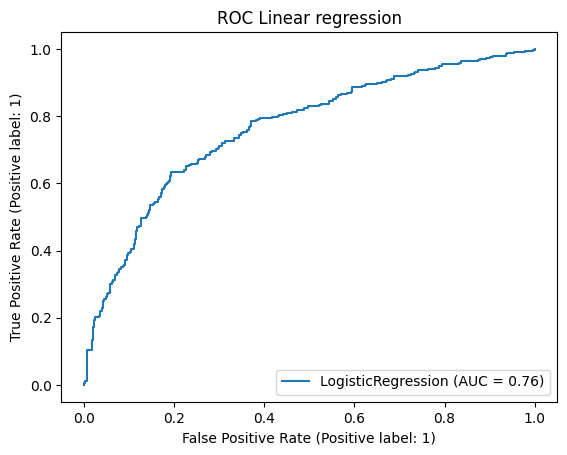

In [9]:
# testing
predictions = model.predict(X_test_selected)
# predictions_proba = np.argmax(model.predict_proba(X_test_selected), axis=1)
conf_mat = confusion_matrix(y_test, predictions)
print(f"Confusion Matrix:\n{conf_mat}\n\n")

# classification report
print(classification_report(y_test, predictions, labels=[0, 1]))#, target_names=['Healthy', 'Lesion']))


# Plotting ROC curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(model, X_test_selected, y_test, ax=ax)
plt.title("ROC Linear regression")
plt.show()

Next step is try with other classification algorithms (Eg. non-linear regression, NB, KNN, DT, SVM) as well as tweaking parameters.

In [16]:
# ------------------------------------------------------- Decision Trees ----------------------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

DT_classifier = DecisionTreeClassifier()

# Trying to select again the significant features to see if it returns the same ones or not
selector = SelectFromModel(estimator=DT_classifier, threshold='median') 
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]

X_train_selected = selector.transform(X_train) # reduce X to the selected features
X_test_selected = selector.transform(X_test)


# Grid of the parameters for later testing
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 4, 8, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 7, 10, 12],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_leaf_nodes': [2, 5, 7, 9, 12, 15, 20]
}

DT_random = RandomizedSearchCV(estimator = DT_classifier, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [17]:
# show selected features that passed the criteria
print(f"Selected {X_train_selected.shape[1]} features!")
print(f"\n\nThe selected features were:\n{selector.get_feature_names_out()}")

Selected 75 features!


The selected features were:
['original_shape_Elongation' 'wavelet2-LHL_gldm_LargeDependenceEmphasis'
 'wavelet-HHH_glrlm_LongRunEmphasis' 'wavelet2-LHH_glrlm_RunPercentage'
 'log-sigma-3-0-mm-3D_glrlm_RunPercentage'
 'wavelet-LLH_glrlm_LongRunLowGrayLevelEmphasis'
 'original_glrlm_RunPercentage'
 'wavelet-HHH_glrlm_LongRunLowGrayLevelEmphasis'
 'log-sigma-3-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis'
 'wavelet2-LHL_glrlm_RunPercentage' 'wavelet-LHL_glrlm_RunEntropy'
 'wavelet-HHH_glrlm_ShortRunEmphasis'
 'wavelet2-LHL_glrlm_RunLengthNonUniformityNormalized'
 'wavelet-HHH_firstorder_InterquartileRange'
 'wavelet2-LLH_glrlm_LongRunLowGrayLevelEmphasis'
 'wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation'
 'wavelet2-HLL_gldm_LargeDependenceLowGrayLevelEmphasis'
 'wavelet-LHL_glrlm_LongRunLowGrayLevelEmphasis'
 'wavelet-LHH_firstorder_InterquartileRange'
 'wavelet-HHL_glrlm_ShortRunEmphasis'
 'wavelet-LHL_glrlm_ShortRunLowGrayLevelEmphasis'
 'wavelet-LLH_firs

The selected features for the Linear regression model and the Decision Trees model were saved in an excel file to be analyzed and see if they selected different features as significant depending on the model.

In [18]:
selected_df = pd.read_excel('selected_features.xlsx', header=None) # loading the excel file with the selected features for LR and DT

different_features = [] # list to be filled with the different features
features_DT = list(selected_df.iloc[0, :]) # loading the features into lists
features_LR = list(selected_df.iloc[1, :])

for feature in features_DT:
    if feature in features_LR: # if the feature of DT exists in the LR list, then continue
        continue
    else:
        different_features.append(feature)

print(f"{len(different_features)} different features between the Linear regression selector and the Decision trees selector")
different_features

41 different features between the Linear regression selector and the Decision trees selector


['original_shape_Elongation',
 'wavelet2-HHH_glrlm_RunLengthNonUniformityNormalized',
 'wavelet-LLH_glrlm_LongRunLowGrayLevelEmphasis',
 'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis',
 'log-sigma-3-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis',
 'wavelet2-LLH_glrlm_LongRunLowGrayLevelEmphasis',
 'wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation',
 'wavelet-LHL_glrlm_ShortRunLowGrayLevelEmphasis',
 'wavelet2-LLH_glszm_ZonePercentage',
 'wavelet-LLH_glrlm_ShortRunEmphasis',
 'wavelet-HHL_glrlm_ShortRunLowGrayLevelEmphasis',
 'wavelet-LLH_gldm_DependenceNonUniformityNormalized',
 'wavelet2-LLH_gldm_SmallDependenceEmphasis',
 'original_glszm_ZonePercentage',
 'wavelet2-HHL_glrlm_ShortRunLowGrayLevelEmphasis',
 'log-sigma-3-0-mm-3D_gldm_SmallDependenceEmphasis',
 'wavelet2-LHL_glrlm_LongRunLowGrayLevelEmphasis',
 'wavelet2-HHH_glrlm_ShortRunLowGrayLevelEmphasis',
 'wavelet2-LLH_glszm_LargeAreaLowGrayLevelEmphasis',
 'wavelet-LLL_glrlm_RunVariance',
 'wavelet-HLH_glrlm_ShortRunLowGrayLe

### Load the model if it is saved locally

In [25]:
best_random = joblib.load("Models/DT_best_estimator.keras")
best_params = joblib.load("Models/DT_best_params.keras")

In [24]:
# !!!!!!!! Skip this cell if the model is already loaded !!!!!!!!!!!!!!!

# Fitting the randomized search model for DT
DT_random.fit(X_train_selected, y_train)

# Getting the best parameters and estimator
best_random = DT_random.best_estimator_
best_params = DT_random.best_params_
print(f"best params: {best_params}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
best params: {'splitter': 'best', 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_leaf_nodes': 15, 'max_depth': 15, 'criterion': 'gini'}


In [26]:
# Predict the labels of the test set using the best model
y_pred_BE = best_random.predict(X_test_selected)

print(f"best params: {best_params}")

best params: {'splitter': 'random', 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_leaf_nodes': 20, 'max_depth': 30, 'criterion': 'gini'}


### Saving the model so it doesn't need to be fitted again

In [21]:
# Saving the model so it doesn't need to be fitted again -> saving the best parameters and best estimator found by hte randomized search
joblib.dump(best_random, "Models/DT_best_estimator.keras")
joblib.dump(best_params, "Models/DT_best_params.keras")

['Models/DT_best_params.keras']

In [27]:
# Base model for Decision Trees
DT_classifier_base = DecisionTreeClassifier(random_state=10)
DT_classifier_base.fit(X_train_selected, y_train)
y_pred = DT_classifier_base.predict(X_test_selected)


# Getting accuracy of both models to compare
accuracy_base = accuracy_score(y_test, y_pred)
print(f"Accuracy base: {accuracy_base}")

accuracy_best = accuracy_score(y_test, y_pred_BE)
print(f"Accuracy best: {accuracy_best}")

print(f'Improvement of {round((100 * (accuracy_best - accuracy_base) / accuracy_base), 3)}% with the randomized search for parameters')

Accuracy base: 0.697054698457223
Accuracy best: 0.7223001402524544
Improvement of 3.622% with the randomized search for parameters


Confusion Matrix:
[[372  35]
 [163 143]]


              precision    recall  f1-score   support

           0       0.70      0.91      0.79       407
           1       0.80      0.47      0.59       306

    accuracy                           0.72       713
   macro avg       0.75      0.69      0.69       713
weighted avg       0.74      0.72      0.70       713

random_min_samples_split7_min_samples_leaf2_max_leaf_nodes20_max_depth30_gini


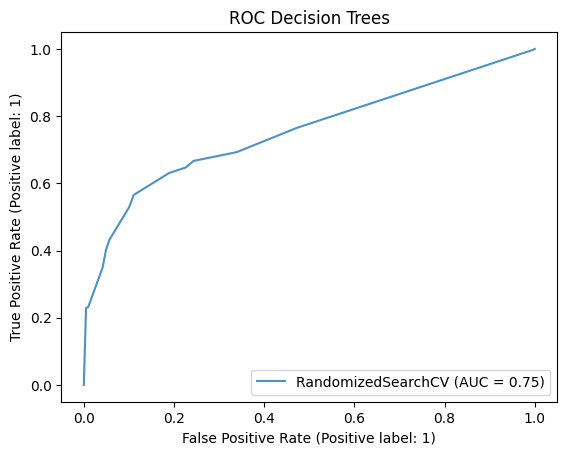

In [28]:
conf_mat = confusion_matrix(y_test, y_pred_BE)
print(f"Confusion Matrix:\n{conf_mat}\n\n")

# classification report
print(classification_report(y_test, y_pred_BE, labels=[0, 1]))#, target_names=['Healthy', 'Lesion']))

# getting the best parameters in a string to be saved in the ROC curve figure
parameters_name = []
for key, value in best_params.items():
    if key == 'splitter' or key=='criterion': key=''
    parameters_name.append(f"{key}{str(value)}")

parameters_name = '_'.join(parameters_name)
print(parameters_name)

# ROC curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(DT_random, X_test_selected, y_test, ax=ax, alpha=0.8)
plt.title("ROC Decision Trees")
plt.savefig(f"Results/DT_{parameters_name}.png")
plt.show()

## Random Forest

In [65]:
# ----------------------------------------------------------- Random Forest -------------------------------------------------------

RF_classifier = RandomForestClassifier()

# Trying to select again the significant features to see if it returns the same ones or not
selector = SelectFromModel(estimator=RF_classifier, threshold='median') 
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]

X_train_selected = selector.transform(X_train) # reduce X to the selected features
X_test_selected = selector.transform(X_test)

# Grid of the parameters for later testing
n_estimators = [int(x) for x in np.linspace(start=50, stop=1000, num=10)] # Number of trees in random forest
max_features = ['auto', 'sqrt', 'log2'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(40, 200, num=11)] # Maximum number of levels in tree

# creating the grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'max_leaf_nodes': [48, 52, 80, 120, 150, 180, 200]}

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=RF_classifier, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs = -1)

In [66]:
# show selected features that passed the criteria
print(f"Selected {X_train_selected.shape[1]} features!")
print(f"\n\nThe selected features were:\n{selector.get_feature_names_out()}")

Selected 75 features!


The selected features were:
['original_shape_Elongation' 'original_firstorder_Kurtosis'
 'original_firstorder_Skewness' 'wavelet-LHL_gldm_LargeDependenceEmphasis'
 'wavelet-LHL_glrlm_LongRunEmphasis'
 'wavelet-LHH_glrlm_RunLengthNonUniformityNormalized'
 'wavelet-LHL_glrlm_RunPercentage'
 'wavelet-HHH_glrlm_RunLengthNonUniformityNormalized'
 'wavelet-LHH_glrlm_ShortRunEmphasis' 'wavelet-HHH_glrlm_RunPercentage'
 'original_glrlm_RunLengthNonUniformityNormalized'
 'wavelet-HHH_glrlm_LongRunLowGrayLevelEmphasis'
 'wavelet-LHL_glrlm_RunLengthNonUniformityNormalized'
 'wavelet-HHH_glrlm_ShortRunEmphasis'
 'wavelet-HHH_firstorder_InterquartileRange'
 'wavelet2-LLH_glrlm_LongRunLowGrayLevelEmphasis'
 'wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation'
 'wavelet-HHH_firstorder_RobustMeanAbsoluteDeviation'
 'wavelet2-HLL_gldm_LargeDependenceLowGrayLevelEmphasis'
 'wavelet-LHL_glrlm_LongRunLowGrayLevelEmphasis'
 'wavelet-LHH_firstorder_InterquartileRange'
 'wavelet-LHH_f

### Load the model if it is saved locally

In [31]:
best_random = joblib.load("Models/RF_best_estimator.keras")
best_params = joblib.load("Models/RF_best_params.keras")

In [67]:
# !!!!!!!!!!!!!!!!!!!!!!!! Skip this cell if you already have the model in your computer !!!!!!!!!!!!!!!!!!!!!

# Fit the random search model
rf_random.fit(X_train_selected, y_train)

# Getting the best parameters and estimator
best_random = rf_random.best_estimator_
best_params = rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
87 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Python311\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 96, in validate_p

In [68]:
# Getting the best parameters and estimator
print(f"best params: {best_params}")

# Predict the labels of the test set using the best model
y_pred_BERF = best_random.predict(X_test_selected)

best params: {'n_estimators': 1000, 'max_leaf_nodes': 180, 'max_features': 'sqrt', 'max_depth': 88}


### Saving the model so it doesn't need to be fitted again

In [71]:
# Saving the model so it doesn't need to be fitted again -> saving the best parameters and best estimator found by hte randomized search
joblib.dump(best_random, "Models/RF_best_estimator.keras")
joblib.dump(best_params, "Models/RF_best_params.keras")

['Models/RF_best_params.keras']

In [69]:
# Base model for Decision Trees
RF_classifier_base = RandomForestClassifier(random_state=10)
RF_classifier_base.fit(X_train_selected, y_train)
y_pred = RF_classifier_base.predict(X_test_selected)


# Getting accuracy of both models to compare
accuracy_base = accuracy_score(y_test, y_pred)
print(f"Accuracy base: {accuracy_base}")

accuracy_best = accuracy_score(y_test, y_pred_BERF)
print(f"Accuracy best: {accuracy_best}")

print(f'Improvement of {round((100 * (accuracy_best - accuracy_base) / accuracy_base), 3)}% with the randomized search for parameters')

Accuracy base: 0.7671809256661991
Accuracy best: 0.7713884992987378
Improvement of 0.548% with the randomized search for parameters


Confusion Matrix:
[[363  44]
 [119 187]]


              precision    recall  f1-score   support

           0       0.75      0.89      0.82       407
           1       0.81      0.61      0.70       306

    accuracy                           0.77       713
   macro avg       0.78      0.75      0.76       713
weighted avg       0.78      0.77      0.77       713

n_estimators1000_max_leaf_nodes180_sqrt_max_depth88


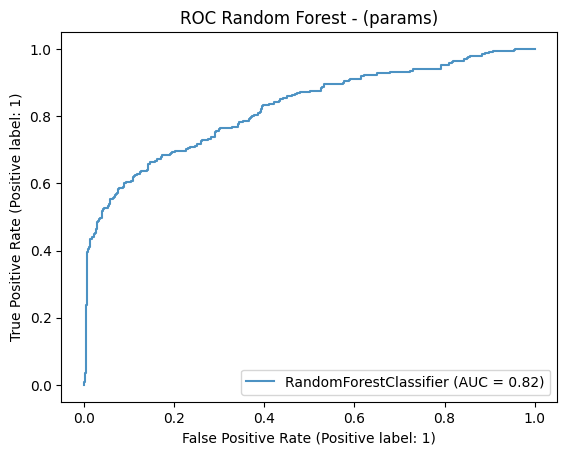

In [70]:
conf_mat = confusion_matrix(y_test, y_pred_BERF)
print(f"Confusion Matrix:\n{conf_mat}\n\n")

# classification report
print(classification_report(y_test, y_pred_BERF, labels=[0, 1]))#, target_names=['Healthy', 'Lesion']))

# getting the best parameters in a string to be saved in the ROC curve figure
parameters_name = []
for key, value in best_params.items():
    if key == 'max_features': key=''
    parameters_name.append(f"{key}{str(value)}")

parameters_name = '_'.join(parameters_name)
print(parameters_name)

# ROC curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(best_random, X_test_selected, y_test, ax=ax, alpha=0.8)
plt.title("ROC Random Forest - (params)")
plt.savefig(f"Results/RF_{parameters_name}")
plt.show()

## KNN Classifier

In [72]:
# ----------------------------------------------------------- K-Nearest Neighbor -------------------------------------------------------

knn = KNeighborsClassifier()

# Trying to select again the significant features to see if it returns the same ones or not
selector = k_best_selector = SelectKBest(score_func=f_classif, k=75)
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]

X_train_selected = selector.transform(X_train) # reduce X to the selected features
X_test_selected = selector.transform(X_test)

In [73]:
# show selected features that passed the criteria
print(f"Selected {X_train_selected.shape[1]} features!")
print(f"\n\nThe selected features were:\n{selector.get_feature_names_out()}")

Selected 75 features!


The selected features were:
['original_firstorder_Skewness' 'wavelet-LHL_glrlm_RunVariance'
 'wavelet2-LHL_gldm_LargeDependenceEmphasis'
 'wavelet2-LLH_gldm_LargeDependenceEmphasis'
 'wavelet-LHL_gldm_LargeDependenceEmphasis'
 'wavelet2-LHL_gldm_DependenceVariance' 'wavelet2-LHL_glrlm_RunVariance'
 'wavelet-LHL_glrlm_LongRunEmphasis' 'wavelet-LHH_glrlm_LongRunEmphasis'
 'wavelet-LHH_glrlm_RunPercentage' 'wavelet2-LLH_glrlm_RunVariance'
 'wavelet-LHH_glrlm_RunLengthNonUniformityNormalized'
 'wavelet-HHH_glrlm_LongRunEmphasis' 'wavelet-LHH_glrlm_RunVariance'
 'wavelet2-LLH_glrlm_LongRunEmphasis' 'wavelet2-LHL_glrlm_LongRunEmphasis'
 'wavelet-HHH_glrlm_RunVariance' 'wavelet2-LHH_glrlm_LongRunEmphasis'
 'wavelet2-LHH_glrlm_RunPercentage' 'wavelet-LHL_glrlm_RunPercentage'
 'wavelet-HHH_glrlm_RunLengthNonUniformityNormalized'
 'wavelet2-HHH_glrlm_RunLengthNonUniformityNormalized'
 'wavelet2-HHH_glrlm_RunPercentage'
 'wavelet-LHH_glrlm_LongRunLowGrayLevelEmphasis'
 'wa

### Load the model if it is saved locally

In [75]:
best_random = joblib.load("Models/KNN_best_estimator.keras")
best_params = joblib.load("Models/KNN_best_params.keras")

In [238]:
# !!!!!!!!!!!!!!!!!!!!!!!! Skip this cell if you already have the model in your computer !!!!!!!!!!!!!!!!!!!!!


# Setting the pipeline to get the best parameters
scaler = StandardScaler()
knn = KNeighborsClassifier()
knn.get_params().keys()

operations = [('scaler',scaler), ('knn', knn)]
pipe = Pipeline(operations)

k_values = list(range(1,20))
param_grid = {'knn__n_neighbors': k_values}
grid_KNN = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')
grid_KNN.fit(X_train_selected, y_train)
GridSearchCV(cv=5, estimator=Pipeline(steps=[('scaler', StandardScaler()), ('knn',KNeighborsClassifier())]), param_grid={'knn__n_neighbors': k_values}, scoring='accuracy')

# Seeing the best parameter values
best_random = grid_KNN.best_estimator_
best_params = grid_KNN.best_params_
best_random.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=11))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=11),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 11,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [76]:
# Getting the best parameters and estimator
print(f"best params: {best_params}")

# Predict the labels of the test set using the best model
y_pred_BEKNN = best_random.predict(X_test_selected)

best params: {'knn__n_neighbors': 11}


### Saving the model so it doesn't need to be fitted again

In [241]:
# Saving the model so it doesn't need to be fitted again -> saving the best parameters and best estimator found by hte randomized search
joblib.dump(best_random, "Models/KNN_best_estimator.keras")
joblib.dump(best_params, "Models/KNN_best_params.keras")

['Models/KNN_best_params.keras']

In [77]:
# Base model for Decision Trees
KNN_classifier_base = KNeighborsClassifier(n_neighbors=2)
KNN_classifier_base.fit(X_train_selected, y_train)
y_pred = KNN_classifier_base.predict(X_test_selected)


# Getting accuracy of both models to compare
accuracy_base = accuracy_score(y_test, y_pred)
print(f"Accuracy base: {accuracy_base}")

accuracy_best = accuracy_score(y_test, y_pred_BEKNN)
print(f"Accuracy best: {accuracy_best}")

print(f'Improvement of {round((100 * (accuracy_best - accuracy_base) / accuracy_base), 3)}% with the randomized search for parameters')

Accuracy base: 0.6143057503506312
Accuracy best: 0.7180925666199158
Improvement of 16.895% with the randomized search for parameters


Confusion Matrix:
[[345  62]
 [139 167]]


              precision    recall  f1-score   support

           0       0.71      0.85      0.77       407
           1       0.73      0.55      0.62       306

    accuracy                           0.72       713
   macro avg       0.72      0.70      0.70       713
weighted avg       0.72      0.72      0.71       713

knn__n_neighbors11


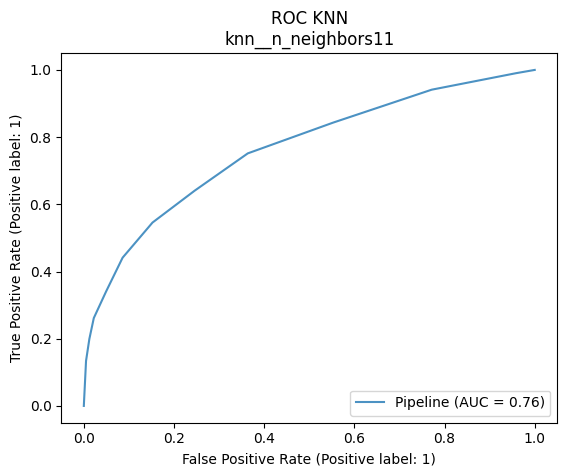

In [78]:
conf_mat = confusion_matrix(y_test, y_pred_BEKNN)
print(f"Confusion Matrix:\n{conf_mat}\n\n")

# classification report
print(classification_report(y_test, y_pred_BEKNN, labels=[0, 1]))#, target_names=['Healthy', 'Lesion']))

# getting the best parameters in a string to be saved in the ROC curve figure
parameters_name = []
for key, value in best_params.items():
    if key == 'weights' or key == 'algorithm': key=''
    parameters_name.append(f"{key}{str(value)}")

parameters_name = '_'.join(parameters_name)
print(parameters_name)

# ROC curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(best_random, X_test_selected, y_test, ax=ax, alpha=0.8)
plt.title(f"ROC KNN\n{parameters_name}")
plt.savefig(f"Results/KNN_{parameters_name}")
plt.show()

## Support Vector Machine (SVM)

In [80]:
# ----------------------------------------------------------- K-Nearest Neighbor -------------------------------------------------------

# Initializing the SVM classifier
svm_classifier = svm.SVC()

# Trying to select again the significant features to see if it returns the same ones or not
selector = k_best_selector = SelectKBest(score_func=f_classif, k=75)
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]

X_train_selected = selector.transform(X_train) # reduce X to the selected features
X_test_selected = selector.transform(X_test)


# Defining the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],  # Relevant for 'poly' kernel
    'coef0': [0.0, 0.1, 0.5]  # Relevant for 'poly' and 'sigmoid' kernels
}

# Performing Grid Search
best_random = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)


### Load the model if you already have it 

In [ ]:
best_random = joblib.load("Models/SVM_best_estimator.keras")
best_params = joblib.load("Models/SVM_best_params.keras")

In [81]:
# !!!!!!!!!!!!!!!!!!!!!!!! Skip this cell if you already have the model in your computer !!!!!!!!!!!!!!!!!!!!!

# Fit the Grid Search to the data
best_random.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = best_random.best_params_
best_estimator = best_random.best_estimator_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


KeyboardInterrupt: 

In [ ]:
# Getting the best parameters and estimator
print(f"best params: {best_params}")

# Predict the labels of the test set using the best model
y_pred_BESVM = best_random.predict(X_test_selected)

### Saving the model so it doesn't have to be fitted again

In [ ]:
# Saving the model so it doesn't need to be fitted again -> saving the best parameters and best estimator found by hte randomized search
joblib.dump(best_random, "Models/SVM_best_estimator.keras")
joblib.dump(best_params, "Models/SVM_best_params.keras")

In [84]:
# Base model for Decision Trees
SVM_classifier_base = svm.SVC()
SVM_classifier_base.fit(X_train_selected, y_train)
y_pred = SVM_classifier_base.predict(X_test_selected)


# Getting accuracy of both models to compare
accuracy_base = accuracy_score(y_test, y_pred)
print(f"Accuracy base: {accuracy_base}")

accuracy_best = accuracy_score(y_test, y_pred_BESVM)
print(f"Accuracy best: {accuracy_best}")

print(f'Improvement of {round((100 * (accuracy_best - accuracy_base) / accuracy_base), 3)}% with the randomized search for parameters')

Accuracy base: 0.6465638148667602


In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_BESVM)
print(f"Confusion Matrix:\n{conf_mat}\n\n")

# classification report
print(classification_report(y_test, y_pred_BESVM, labels=[0, 1]))#, target_names=['Healthy', 'Lesion']))

# getting the best parameters in a string to be saved in the ROC curve figure
parameters_name = []
for key, value in best_params.items():
    if key == 'max_features': key=''
    parameters_name.append(f"{key}{str(value)}")

parameters_name = '_'.join(parameters_name)
print(parameters_name)

# ROC curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(best_random, X_test_selected, y_test, ax=ax, alpha=0.8)
plt.title(f"ROC SVM\n{parameters_name}")
plt.savefig(f"Results/RF_{parameters_name}")
plt.show()